# ライブラリ読み込み

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold

import lightgbm as lgbm

plt.style.use("ggplot")
%matplotlib inline

# 関数読み込み

In [2]:
def rmsle(ans, pred):
    return np.sqrt(np.square(np.log1p(ans) - np.log1p(pred)).mean())

def rmse(ans, pred):
    return np.sqrt(np.square(ans - pred).mean())

In [3]:
def train_test_cat_plot(merged_data, cat_cols, n_col=2):
    n_col = 2
    n_row = len(cat_cols) // n_col + 1

    fig, axes = plt.subplots(n_row,n_col, figsize=(n_col*6, n_row*4))

    for cat_col, ax in zip(cat_cols, axes.flatten()):

        tmp = pd.pivot_table(merged_data, index=cat_col,
                                           columns="train", values='age', aggfunc="count")

        left = np.arange(len(tmp))
        train_ = tmp[0].values / tmp[0].values.sum()
        test_ = tmp[1].values / tmp[1].values.sum()
        
        ax.bar(left, train_ , width=0.4, label="train")
        ax.bar(left+0.5, test_, width=0.4, label="test")
        
        ax.set_ylim(0, max(train_.max(), test_.max())*1.1)
        ax.legend()
        ax.set_xticks(left+0.25) 
        ax.set_xticklabels(tmp.index.values)
        ax.set_title(cat_col)
    plt.show()
    return

In [4]:
def KFold_lgbm_ensemble(train_data, params, num_round=1000, K=5):
    kf = KFold(n_splits=K, random_state=2019, shuffle=True)
    split = kf.split(train_data)
    models = []
    rmsles = []
    for train_idx, val_idx in split:
        train_x = train_data.drop("charges", axis=1).values
        train_y = train_data["charges"].map(lambda y: np.log1p(y)).values
        train_x, valid_x = train_x[train_idx], train_x[val_idx]
        train_y, valid_y = train_y[train_idx], train_y[val_idx]

        # 学習
        d_train = lgbm.Dataset(train_x, label=train_y)
        d_valid = lgbm.Dataset(valid_x, label=valid_y)
        
        model = lgbm.train(params = lgbm_params,
                                           train_set =d_train,
                                           valid_sets = d_valid,
                                           num_boost_round = num_round,
                                           early_stopping_rounds = 20,
                                           verbose_eval=50)

        models.append(model)

        valid_pred = model.predict(valid_x)
        rmsles.append(rmse(valid_y, valid_pred))
        
    return models, rmsles

# データ読み込み

In [5]:
DATA_PATH = "data/"
train_data = pd.read_csv(DATA_PATH+"sample_train.csv")
test_data = pd.read_csv(DATA_PATH+"sample_test.csv")
answer_data = pd.read_csv(DATA_PATH+"sample_answer.csv")

In [6]:
train_data.head()

,id,charges,region,smoker,children,bmi,sex,age
0,0,7742.10980,southeast,no,1,26.620,male,46
1,1,8413.46305,northwest,no,2,30.495,male,45
2,2,4058.71245,northwest,no,2,33.155,male,27
3,3,11353.22760,northwest,no,0,31.540,male,57
4,4,5478.03680,southeast,no,1,29.920,female,36


In [7]:
test_data.head()

,id,region,smoker,children,bmi,sex,age
0,0,northwest,no,1,28.310,female,41
1,1,southwest,no,1,22.300,male,21
2,2,southwest,no,5,42.400,male,33
3,3,northwest,no,0,34.485,female,25
4,4,northeast,no,0,31.065,female,31


# データの確認

In [8]:
# 値のチェック
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 8 columns):
id          1070 non-null int64
charges     1070 non-null float64
region      1070 non-null object
smoker      1070 non-null object
children    1070 non-null int64
bmi         1070 non-null float64
sex         1070 non-null object
age         1070 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 67.0+ KB


In [ ]:
# null　チェック
train_data.isnull().sum()

In [ ]:
# 特殊なカテゴリーがあるかチェック
cat_cols = ["region", "smoker", "sex"]
for cat_col in cat_cols:
    print(train_data[cat_col].value_counts())

In [ ]:
# 各種統計量
train_data.describe()

In [ ]:
sns.pairplot(train_data,
                     vars=["charges", "region", "smoker", "children", "bmi", "sex", "age"])
plt.savefig('data/EDA/pairplot.png')
plt.close()

In [ ]:
for col in cat_cols:
    sns.pairplot(train_data, hue = col,
                         vars=["charges", "children", "bmi", "age"])
    plt.savefig(f'data/EDA/{col}_pairplot.png')
    plt.close()

In [ ]:
# train, testの分布を確認
train_data["train"] = 1
test_data["train"] = 0
merged_data = pd.concat([train_data, test_data], sort=False)

sns.pairplot(merged_data, hue="train",
                     vars=["children", "bmi", "age"])
plt.savefig(f'data/EDA/train_test_pairplot.png')
plt.close()

In [ ]:
train_test_cat_plot(merged_data,  cat_cols)

# ベースライン
KFold Ensemble

In [ ]:
train_data["children"] = train_data["children"].map(lambda x : str(x))
test_data["children"] = test_data["children"].map(lambda x : str(x))

train_data = train_data.drop("id", axis=1)
test_data = test_data.drop("id", axis=1)
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

In [ ]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "n_estimators": 1000,
    'num_leaves': 20,
    'max_depth': 6, 
    'learning_rate': 0.01,
    'verbose': -1, 
    "num_threads": 10}

## シングルモデル

In [ ]:
kf = KFold(n_splits=4, random_state=2019, shuffle=True)
split = kf.split(train_data)
train_idx, val_idx = split.__next__()

In [ ]:
train_x = train_data.drop("charges", axis=1).values
train_y = train_data["charges"].map(lambda y: np.log1p(y)).values
train_x, valid_x = train_x[train_idx], train_x[val_idx]
train_y, valid_y = train_y[train_idx], train_y[val_idx]

# 学習
d_train = lgbm.Dataset(train_x, label=train_y)
d_valid = lgbm.Dataset(valid_x, label=valid_y)
model = lgbm.train(params = lgbm_params,
                                   train_set =d_train,
                                   valid_sets = d_valid,
                                   num_boost_round = 1000,
                                   early_stopping_rounds = 20,
                                   verbose_eval=50)

### Private Leaderboard
0.4154697625778434

In [ ]:
test_pred = model.predict(test_data.values)
test_pred = np.exp(test_pred) - 1
print(rmsle(answer_data["charges"].values, test_pred))

## K-Fold Ensemble

In [ ]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

In [ ]:
cv_rmsles = []
for i in range(9):
    K =i+2
    models, rmsles = KFold_lgbm_ensemble(train_data, lgbm_params, K=K)
    cv_rmsles.append(np.mean(rmsles))

In [ ]:
plt.plot(cv_rmsles)
plt.xticks(np.arange(10), np.arange(10)+2);

### Private Leaderboard
0.41444564295755526

In [ ]:
K = 8
models, rmsles = KFold_lgbm_ensemble(train_data, lgbm_params, K=K)

In [ ]:
test_pred = np.zeros(test_data.values.shape[0])
for model in models:
    test_pred_ = model.predict(test_data.values)
    test_pred_ = np.exp(test_pred_) - 1
    test_pred += test_pred_
test_pred = test_pred / K

print(rmsle(answer_data["charges"].values, test_pred))

# lgbm with Denoising AutoEncoder

In [9]:
from sklearn.preprocessing import QuantileTransformer

In [10]:
from get_dae_feature import preprocess, train_dae, get_representation

In [11]:
# 読み込み
train_data = pd.read_csv(DATA_PATH+"sample_train.csv")
test_data = pd.read_csv(DATA_PATH+"sample_test.csv")
train_data["train"] = 1
test_data["train"] = 0
train_y = train_data["charges"].values

num_cols = ["bmi", "age"]
cat_cols = ["children", "region", "smoker", "sex"]

# dae用にmerge
merged_data = pd.concat([train_data, test_data], sort=False)
merged_data = merged_data.drop(["id", "charges"], axis=1)
merged_data["children"] = merged_data["children"].map(lambda x: str(x))

In [12]:
# rankgauss & one hot & swap noise
one_hot_df = preprocess(merged_data, num_cols, cat_cols)

# train, test data
train_x = one_hot_df.query("train == 1").drop("train", axis=1)
test_x = one_hot_df.query("train == 0").drop("train", axis=1)

In [15]:
train_dae(one_hot_df.drop("train", axis=1), "cuda:9", "models/dae.model", cycle=1000)

0.4784675646911968
0.20494306222959
0.13459810479120773
0.10279751162637364
0.08071287179535086
0.06589733538302509
0.05565076863223856
0.04881921715357087
0.04266461086544124
0.03822122615846721


In [16]:
train_x = get_representation(train_x.values, "models/dae.model")
test_x =  get_representation(test_x.values, "models/dae.model")

train_data_ = pd.DataFrame(train_x)
train_data_["charges"] = train_y

## シングルモデル

In [17]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "n_estimators": 1000,
    'num_leaves': 20,
    'max_depth': 6, 
    'learning_rate': 0.01,
    'verbose': -1, 
    "num_threads": 10}

In [18]:
kf = KFold(n_splits=4, random_state=2019, shuffle=True)
split = kf.split(train_data_)
train_idx, val_idx = split.__next__()

train_x = train_data_.drop("charges", axis=1).values
train_y = train_data_["charges"].map(lambda y: np.log1p(y)).values
train_x, valid_x = train_x[train_idx], train_x[val_idx]
train_y, valid_y = train_y[train_idx], train_y[val_idx]

# 学習
d_train = lgbm.Dataset(train_x, label=train_y)
d_valid = lgbm.Dataset(valid_x, label=valid_y)
model = lgbm.train(params = lgbm_params,
                                   train_set =d_train,
                                   valid_sets = d_valid,
                                   num_boost_round = 1000,
                                   early_stopping_rounds = 20,
                                   verbose_eval=50)

/home/k-syo/.local/share/virtualenvs/lgbm-dae-optuna-16RmQPvN/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.735857
[100]	valid_0's rmse: 0.600393
[150]	valid_0's rmse: 0.520285
[200]	valid_0's rmse: 0.477655
[250]	valid_0's rmse: 0.459125
[300]	valid_0's rmse: 0.446398
[350]	valid_0's rmse: 0.44269
[400]	valid_0's rmse: 0.441671
Early stopping, best iteration is:
[417]	valid_0's rmse: 0.441506


### Private Leaderbord
0.4552257580531059

In [19]:
test_pred = model.predict(test_x)
test_pred = np.exp(test_pred) - 1
print(rmsle(answer_data["charges"].values, test_pred))

0.4552257580531059


## K-Fold Ensembel

In [20]:
cv_rmsles = []
for i in range(9):
    K =i+2
    models, rmsles = KFold_lgbm_ensemble(train_data_, lgbm_params, K=K)
    cv_rmsles.append(np.mean(rmsles))

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.73181
[100]	valid_0's rmse: 0.606927
[150]	valid_0's rmse: 0.537769
[200]	valid_0's rmse: 0.507737
[250]	valid_0's rmse: 0.487438
[300]	valid_0's rmse: 0.478512
[350]	valid_0's rmse: 0.473457
[400]	valid_0's rmse: 0.471153
[450]	valid_0's rmse: 0.469224
[500]	valid_0's rmse: 0.467879
[550]	valid_0's rmse: 0.467216
[600]	valid_0's rmse: 0.466645
[650]	valid_0's rmse: 0.466376
[700]	valid_0's rmse: 0.465938
[750]	valid_0's rmse: 0.465802
Early stopping, best iteration is:
[732]	valid_0's rmse: 0.465633
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.696234
[100]	valid_0's rmse: 0.586396
[150]	valid_0's rmse: 0.534016
[200]	valid_0's rmse: 0.50199
[250]	valid_0's rmse: 0.484878
[300]	valid_0's rmse: 0.4751
[350]	valid_0's rmse: 0.471361
[400]	valid_0's rmse: 0.470185
Early stopping, best iteration is:
[420]	valid_0's rmse: 0.469916
Training until validation scores don'

[100]	valid_0's rmse: 0.572797
[150]	valid_0's rmse: 0.538316
[200]	valid_0's rmse: 0.520285
[250]	valid_0's rmse: 0.506576
[300]	valid_0's rmse: 0.498468
Early stopping, best iteration is:
[329]	valid_0's rmse: 0.497985
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.721181
[100]	valid_0's rmse: 0.597153
[150]	valid_0's rmse: 0.526665
[200]	valid_0's rmse: 0.489372
[250]	valid_0's rmse: 0.46605
[300]	valid_0's rmse: 0.452757
[350]	valid_0's rmse: 0.441647
[400]	valid_0's rmse: 0.434865
[450]	valid_0's rmse: 0.431803
[500]	valid_0's rmse: 0.429202
[550]	valid_0's rmse: 0.427989
[600]	valid_0's rmse: 0.426591
[650]	valid_0's rmse: 0.425342
[700]	valid_0's rmse: 0.424878
[750]	valid_0's rmse: 0.424182
[800]	valid_0's rmse: 0.423603
Early stopping, best iteration is:
[818]	valid_0's rmse: 0.423397
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.726123
[100]	valid_0's rmse: 0.596356
[150]	valid_0's rmse: 0.540463
[20

[550]	valid_0's rmse: 0.460428
[600]	valid_0's rmse: 0.459109
[650]	valid_0's rmse: 0.458512
[700]	valid_0's rmse: 0.457518
Early stopping, best iteration is:
[711]	valid_0's rmse: 0.457235
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.700813
[100]	valid_0's rmse: 0.588939
[150]	valid_0's rmse: 0.527778
[200]	valid_0's rmse: 0.491653
[250]	valid_0's rmse: 0.47457
[300]	valid_0's rmse: 0.468867
[350]	valid_0's rmse: 0.464646
[400]	valid_0's rmse: 0.46125
[450]	valid_0's rmse: 0.459619
[500]	valid_0's rmse: 0.458411
[550]	valid_0's rmse: 0.456712
[600]	valid_0's rmse: 0.455206
[650]	valid_0's rmse: 0.454215
[700]	valid_0's rmse: 0.453198
[750]	valid_0's rmse: 0.451224
[800]	valid_0's rmse: 0.450886
Early stopping, best iteration is:
[784]	valid_0's rmse: 0.450619
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.669633
[100]	valid_0's rmse: 0.546482
[150]	valid_0's rmse: 0.482693
[200]	valid_0's rmse: 0.454569
[250

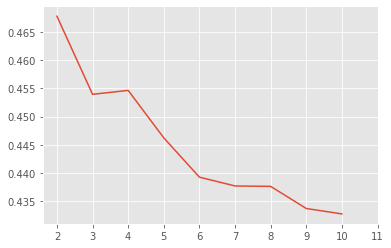

In [21]:
plt.plot(cv_rmsles)
plt.xticks(np.arange(10), np.arange(10)+2);

### Private Leaderbord
0.4385008765807142

In [22]:
K = 10
models, rmsles = KFold_lgbm_ensemble(train_data_, lgbm_params, K=K)

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.724316
[100]	valid_0's rmse: 0.573691
[150]	valid_0's rmse: 0.495498
[200]	valid_0's rmse: 0.450757
[250]	valid_0's rmse: 0.425303
[300]	valid_0's rmse: 0.410947
[350]	valid_0's rmse: 0.402416
[400]	valid_0's rmse: 0.397167
[450]	valid_0's rmse: 0.394848
[500]	valid_0's rmse: 0.392648
[550]	valid_0's rmse: 0.391642
Early stopping, best iteration is:
[539]	valid_0's rmse: 0.391595
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.731983
[100]	valid_0's rmse: 0.592559
[150]	valid_0's rmse: 0.520588
[200]	valid_0's rmse: 0.480708
[250]	valid_0's rmse: 0.462212
[300]	valid_0's rmse: 0.459867
Early stopping, best iteration is:
[327]	valid_0's rmse: 0.459082
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.691069
[100]	valid_0's rmse: 0.580143
[150]	valid_0's rmse: 0.52211
[200]	valid_0's rmse: 0.487767
[250]	valid_0's rmse: 0.46181
[300]

In [25]:
np.mean(rmsles)

0.43273873159241444

In [23]:
test_pred = np.zeros(test_x.shape[0])
for model in models:
    test_pred_ = model.predict(test_x)
    test_pred_ = np.exp(test_pred_) - 1
    test_pred += test_pred_
test_pred = test_pred / K

print(rmsle(answer_data["charges"].values, test_pred))

0.4385008765807142
